### **Import Library**

In [26]:
# Mengimpor pustaka google_play_scraper untuk mengakses ulasan dan informasi aplikasi dari Google Play Store.
from google_play_scraper import app, reviews, Sort
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import time
import re

### **Scraping Dataset**

In [27]:
# Scraping Data

app_id = 'com.whatsapp'  # Package name aplikasi Whatsapp di Play Store
jumlah_total_ulasan = 11000  # Jumlah total ulasan bahasa Indonesia
batch_size = 200    # Jumlah ulasan setiap batch
lokasi = 'id'       # Kode negara (Indonesia)
bahasa = 'id'     # Kode bahasa (Indonesia)

print(f"Jumlah ulasan yang diambil {jumlah_total_ulasan} ulasan dalam bahasa {bahasa} dari aplikasi Whatsapp di Play Store")

ulasan_whatsapp = []
continuation_token = None
for i in range(0, jumlah_total_ulasan, batch_size):
    try:
        result, continuation_token = reviews(
            app_id,
            lang=bahasa,
            country=lokasi,
            sort=Sort.NEWEST,
            count=batch_size,
            continuation_token=continuation_token
        )
        for review in result:
            ulasan_whatsapp.append({
                'reviewId': review['reviewId'],
                'userName': review['userName'],
                'content': review['content'],
                'score': review['score'],  # Rating bintang
                'thumbsUpCount': review['thumbsUpCount'],
                'at': review['at'],  # Tanggal dan waktu ulasan dibuat
                'language': bahasa # Informasi bahasa
            })
    except Exception as e:
        print(f"Terjadi error saat mengambil ulasan pada batch ke-{(i // batch_size) + 1}: {e}")
        break

print(f"Berhasil mengumpulkan total {len(ulasan_whatsapp)} ulasan dalam bahasa {bahasa}.")

# Buat DataFrame dari hasil scraping awal
reviews_df = pd.DataFrame(ulasan_whatsapp)

print("\nData ulasan Whatsapp yang berhasil di-scrape:")
display(reviews_df.head())

Jumlah ulasan yang diambil 11000 ulasan dalam bahasa id dari aplikasi Whatsapp di Play Store
Berhasil mengumpulkan total 11000 ulasan dalam bahasa id.

Data ulasan Whatsapp yang berhasil di-scrape:


,reviewId,userName,content,score,thumbsUpCount,at,language
0,275d6a3b-2584-4dd2-a358-4ec654752fda,lala,"wa skrang nge bug parah,tiba"" ada notifikasi t...",1,0,2025-04-04 12:08:52,id
1,98ef73dc-b72d-4c7b-b275-9b0b874bb6d4,Rice Kosmar,sangat bagus,5,0,2025-04-04 12:08:31,id
2,0eead298-60ff-422f-927d-a506bf1d9ccd,Diansyah Diansyah,Sangat membantu,3,0,2025-04-04 12:07:54,id
3,e9f2b7ad-5170-4f6e-b560-758dc11e5a7a,Gladiez Arkan,kecewa ga bisa bikin status,1,0,2025-04-04 12:07:48,id
4,8d1578b2-25ed-4096-9e81-db731c2f1a80,Keyla,suka,5,0,2025-04-04 12:07:45,id


In [28]:
# Exploratory Data Analysis (EDA)

# Cek dan Tangani missing values
print("\nJumlah nilai yang hilang (NaN) per kolom:")
print(reviews_df.isnull().sum())
cleaned_reviews_df = reviews_df.dropna()
print(f"\nJumlah baris setelah menghapus nilai yang hilang: {len(cleaned_reviews_df)}")

# Cek dan Tangani duplikat
print("\nJumlah baris duplikat:")
print(cleaned_reviews_df.duplicated().sum())
cleaned_reviews_df = cleaned_reviews_df.drop_duplicates()
print(f"\nJumlah baris setelah menghapus duplikat: {len(cleaned_reviews_df)}\n")


Jumlah nilai yang hilang (NaN) per kolom:
reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
language         0
dtype: int64

Jumlah baris setelah menghapus nilai yang hilang: 11000

Jumlah baris duplikat:
0

Jumlah baris setelah menghapus duplikat: 11000



In [29]:
print(cleaned_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reviewId       11000 non-null  object        
 1   userName       11000 non-null  object        
 2   content        11000 non-null  object        
 3   score          11000 non-null  int64         
 4   thumbsUpCount  11000 non-null  int64         
 5   at             11000 non-null  datetime64[ns]
 6   language       11000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 601.7+ KB
None


### **Preprocessing Text**

In [30]:
# Unduh resources
try:
    stopwords.words('indonesian')
except LookupError:
    nltk.download('stopwords')

try:
    stopwords.words('english')
except LookupError:
    nltk.download('english')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text

def casefolding_text(text):
    return text.lower()

def fix_slangwords(text):
    slang_map = {
        'yg': 'yang', 'bgt': 'banget', 'ga': 'tidak', 'gak': 'tidak', 'tdk':'tidak', 'dgn': 'dengan', 'utk': 'untuk', 'dll': 'dan lain-lain', 'gue': 'saya', 'gw': 'saya', 'lo': 'kamu', 'loe': 'kamu', 'bro': 'saudara', 'sis': 'saudari', 'tapi': 'tetapi', 'tp': 'tetapi', 'karna': 'karena', 'krn': 'karena', 'banget': 'sangat', 'bangga': 'sangat', 'udah': 'sudah', 'sdh': 'sudah', 'blm': 'belum', 'aja': 'saja', 'aje': 'saja', 'masa': 'sungguh', 'msh': 'masih', 'knp': 'kenapa', 'kenapa': 'mengapa', 'kok': 'mengapa', 'gini': 'begini', 'gitu': 'begitu', 'kayak': 'seperti', 'kyk': 'seperti', 'abis': 'habis', 'nih': 'ini', 'sih': 'partikel', 'dong': 'partikel', 'lah': 'partikel', 'kek': 'seperti', 
        'lebay': 'berlebihan', 'alay': 'norak', 'bete': 'kesal', 'males': 'malas', 'bener': 'benar', 'bner': 'benar', 'yey': 'hore', 'asli': 'sungguh', 'parah': 'sangat buruk', 'anjir': 'ungkapan terkejut/kesal', 'wih': 'ungkapan kagum', 'keren': 'sangat bagus', 'abis': 'habis', 'dikit': 'sedikit', 'dikid': 'sedikit', 'napa': 'kenapa', 'yak': 'iya', 'yes': 'iya', 'no': 'tidak', 'pls': 'tolong', 'please': 'tolong', 'thx': 'terima kasih', 'thanks': 'terima kasih', 'tq': 'terima kasih', 'mantul': 'mantap betul', 'gokil': 'keren sekali', 'cekidot': 'mari kita lihat', 'kuy': 'mari', 'santuy': 'santai', 'selow': 'santai', 'baper': 'bawa perasaan', 'mager': 'malas gerak', 'halu': 'berkhayal', 
        'kepo': 'ingin tahu', 'anjay': 'ungkapan terkejut/kagum', 'fix': 'pasti', 'auto': 'otomatis', 'btw': 'ngomong-ngomong', 'cm': 'cuma', 'cuman': 'cuma', 'dpt': 'dapat', 'nemu': 'menemukan', 'jg': 'juga','apk':'aplikasi', 'aplikasinya':'aplikasi', 'vidio':'video', 'wa':'whatsapp', 'bkin':'buat', 'gajelas':'tidak jelas', 'kalo':'kalau', 'makin':'semakin', 'pisan':'banget', 'hade':'jernih', 'sukar':'suka',
        'bgus':'bagus', 'membatu':'membantu', 'muantap':'mantap', 'mantab':'mantap', 'kece':'keren','josss':'mantap', 'baikkkkkk':'baik','trima':'terima','knp':'kenapa', 'kok':'kenapa',
        'bgs':'bagus', 'eror':'error', 'sanagat':'sangat', 'gk':'tidak',
        'u': 'you', 'r': 'are', 'ur': 'your', 'y': 'why', 'lol': 'laughing out loud', 'lmao': 'laughing my ass off', 'omg': 'oh my god', 'idk': 'i don\'t know', 'imo': 'in my opinion', 'imho': 'in my humble opinion', 'fyi': 'for your information', 'btw': 'by the way', 'asap': 'as soon as possible', 'tbh': 'to be honest', 'ikr': 'i know, right?', 'smh': 'shaking my head', 'tbf': 'to be fair', 'nvm': 'never mind', 'wth': 'what the heck', 'wtf': 'what the f***', 'gtg': 'got to go', 'brb': 'be right back', 'aka': 'also known as', 'cuz': 'because', 'thru': 'through', 'tho': 'though', 'gonna': 'going to', 'wanna': 'want to', 'gotta': 'got to', 'kinda': 'kind of', 'sorta': 'sort of'
    }
    words = text.split()
    return ' '.join([slang_map.get(word, word) for word in words])

def tokenizing_text(text):
    return word_tokenize(text)

def handle_negation(tokens):
    negation = False
    negation_words_id = {"tidak", "bukan", "jangan", "tak", "tiada"}
    negation_words_en = {"not", "no", "never"}
    negated_tokens = []
    for token in tokens:
        if token in negation_words_id or token in negation_words_en:
            negation = True
            negated_tokens.append(token)
        elif negation and token not in string.punctuation:
            negated_tokens.append("NEG_" + token)
        else:
            negation = False
            negated_tokens.append(token)
        if token in string.punctuation: # Reset negasi jika bertemu tanda baca
            negation = False
    return negated_tokens

def filtering_stopwords(tokens, language):
    stop_words_indonesian = set(stopwords.words('indonesian'))
    stop_words_english = set(stopwords.words('english'))
    punctuation = string.punctuation
    negation_words_id = {"tidak", "bukan", "jangan", "tak", "tiada"} # Kata negasi bahasa Indonesia
    negation_words_en = {"not", "no", "never"} # Kata negasi bahasa Inggris
    filtered_tokens = []
    for w in tokens:
        if language == 'id':
            if not w in stop_words_indonesian or w in negation_words_id: 
                if not w in punctuation:
                    filtered_tokens.append(w)
        elif language == 'en':
            if not w in stop_words_english or w in negation_words_en: 
                if not w in punctuation:
                    filtered_tokens.append(w)
        else:
            filtered_tokens.append(w) 
    return filtered_tokens

def to_sentence(tokens):
    return " ".join(tokens)
    
def normalize_space(text):
    return re.sub(r'\s+', ' ', text).strip()

cleaned_reviews_df['text_clean'] = cleaned_reviews_df['content'].apply(clean_text)
cleaned_reviews_df['text_casefoldingText'] = cleaned_reviews_df['text_clean'].apply(casefolding_text)
cleaned_reviews_df['text_slangwords'] = cleaned_reviews_df['text_casefoldingText'].apply(fix_slangwords)
cleaned_reviews_df['text_normalized_space'] = cleaned_reviews_df['text_slangwords'].apply(normalize_space)
cleaned_reviews_df['text_tokenizingText'] = cleaned_reviews_df['text_normalized_space'].apply(tokenizing_text)
cleaned_reviews_df['text_tokenizingText'] = cleaned_reviews_df['text_slangwords'].apply(tokenizing_text)
cleaned_reviews_df['text_negation'] = cleaned_reviews_df['text_tokenizingText'].apply(handle_negation) # Penanganan negasi
cleaned_reviews_df['text_stopword'] = cleaned_reviews_df.apply(lambda row: filtering_stopwords(row['text_negation'], row['language']), axis=1) # Hasil penanganan negasi
cleaned_reviews_df['text_akhir'] = cleaned_reviews_df['text_stopword'].apply(to_sentence)
cleaned_reviews_df['content_processed'] = cleaned_reviews_df['text_akhir']

print("\nHasil preprocessing teks dengan penanganan negasi:")
display(cleaned_reviews_df[['content', 'text_clean', 'text_casefoldingText', 'text_slangwords', 'text_tokenizingText', 'text_negation', 'text_stopword', 'text_akhir']].head())

# DataFrame setelah preprocessing
print("\nDataFrame setelah preprocessing teks dengan penanganan negasi:")
kolom_tampilan = ['reviewId', 'userName', 'content', 'score', 'thumbsUpCount', 'at', 'language', 'text_clean', 'text_casefoldingText', 'text_slangwords', 'text_tokenizingText', 'text_negation', 'text_stopword', 'text_akhir']
display(cleaned_reviews_df[kolom_tampilan].head())
print("\nInformasi DataFrame setelah preprocessing dengan penanganan negasi:")
display(cleaned_reviews_df[kolom_tampilan].info())


Hasil preprocessing teks dengan penanganan negasi:


,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_negation,text_stopword,text_akhir
0,"wa skrang nge bug parah,tiba"" ada notifikasi t...","wa skrang nge bug parah,tiba"" ada notifikasi t...","wa skrang nge bug parah,tiba"" ada notifikasi t...","whatsapp skrang nge bug parah,tiba"" ada notifi...","[whatsapp, skrang, nge, bug, parah, ,, tiba, '...","[whatsapp, skrang, nge, bug, parah, ,, tiba, '...","[whatsapp, skrang, nge, bug, parah, '', notifi...",whatsapp skrang nge bug parah '' notifikasi ke...
1,sangat bagus,sangat bagus,sangat bagus,sangat bagus,"[sangat, bagus]","[sangat, bagus]",[bagus],bagus
2,Sangat membantu,Sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]","[sangat, membantu]",[membantu],membantu
3,kecewa ga bisa bikin status,kecewa ga bisa bikin status,kecewa ga bisa bikin status,kecewa tidak bisa bikin status,"[kecewa, tidak, bisa, bikin, status]","[kecewa, tidak, NEG_bisa, NEG_bikin, NEG_status]","[kecewa, tidak, NEG_bisa, NEG_bikin, NEG_status]",kecewa tidak NEG_bisa NEG_bikin NEG_status
4,suka,suka,suka,suka,[suka],[suka],[suka],suka



DataFrame setelah preprocessing teks dengan penanganan negasi:


,reviewId,userName,content,score,thumbsUpCount,at,language,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_negation,text_stopword,text_akhir
0,275d6a3b-2584-4dd2-a358-4ec654752fda,lala,"wa skrang nge bug parah,tiba"" ada notifikasi t...",1,0,2025-04-04 12:08:52,id,"wa skrang nge bug parah,tiba"" ada notifikasi t...","wa skrang nge bug parah,tiba"" ada notifikasi t...","whatsapp skrang nge bug parah,tiba"" ada notifi...","[whatsapp, skrang, nge, bug, parah, ,, tiba, '...","[whatsapp, skrang, nge, bug, parah, ,, tiba, '...","[whatsapp, skrang, nge, bug, parah, '', notifi...",whatsapp skrang nge bug parah '' notifikasi ke...
1,98ef73dc-b72d-4c7b-b275-9b0b874bb6d4,Rice Kosmar,sangat bagus,5,0,2025-04-04 12:08:31,id,sangat bagus,sangat bagus,sangat bagus,"[sangat, bagus]","[sangat, bagus]",[bagus],bagus
2,0eead298-60ff-422f-927d-a506bf1d9ccd,Diansyah Diansyah,Sangat membantu,3,0,2025-04-04 12:07:54,id,Sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]","[sangat, membantu]",[membantu],membantu
3,e9f2b7ad-5170-4f6e-b560-758dc11e5a7a,Gladiez Arkan,kecewa ga bisa bikin status,1,0,2025-04-04 12:07:48,id,kecewa ga bisa bikin status,kecewa ga bisa bikin status,kecewa tidak bisa bikin status,"[kecewa, tidak, bisa, bikin, status]","[kecewa, tidak, NEG_bisa, NEG_bikin, NEG_status]","[kecewa, tidak, NEG_bisa, NEG_bikin, NEG_status]",kecewa tidak NEG_bisa NEG_bikin NEG_status
4,8d1578b2-25ed-4096-9e81-db731c2f1a80,Keyla,suka,5,0,2025-04-04 12:07:45,id,suka,suka,suka,[suka],[suka],[suka],suka



Informasi DataFrame setelah preprocessing dengan penanganan negasi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              11000 non-null  object        
 1   userName              11000 non-null  object        
 2   content               11000 non-null  object        
 3   score                 11000 non-null  int64         
 4   thumbsUpCount         11000 non-null  int64         
 5   at                    11000 non-null  datetime64[ns]
 6   language              11000 non-null  object        
 7   text_clean            11000 non-null  object        
 8   text_casefoldingText  11000 non-null  object        
 9   text_slangwords       11000 non-null  object        
 10  text_tokenizingText   11000 non-null  object        
 11  text_negation         11000 non-null  object        
 12  text_

None

In [31]:
# Analisis Sentimen Berbasis Leksikon (dengan Kata Netral)

# Leksikon
positive_words_id = ['bagus', 'baik', 'Baik', 'senang', 'puas', 'membantu', 'mudah', 'mantap', 'nice', 'pas', 'terimakasih', 
                    'kasih', 'bermanfaat', 'stabil', 'lancar', 'top', 'rekomendasi', 'suka', 'hebat', 'luar biasa', 
                    'memuaskan', 'terima kasih', 'responsif', 'efektif', 'berhasil', 'istimewa', 'sempurna', 'trimakasih', 
                    'menyenangkan', 'keren', 'sip', 'oke', 'terbaik', 'terpercaya', 'unggul', 'baguss', 'best', 'aman', 
                    'amanah', 'alhamdulillah', 'good job', 'makasih', 'ok', 'good', 'sukses', 'jos', 'bagusss', 'memudahkan', 
                    'canggih', 'sesuai', 'semangat', 'berguna', 'bgus', 'gampang', 'ya', 'cepet', 'lengkap', 'okey', 'seru', 
                    'nikmat', 'jossss', 'estetik', 'lovyu', 'bestttt', 'wokeh', 'cantik', 'keren banget', 'mantappp', 
                    'sangat bagus', 'super', 'nyaman', 'praktis', 'mudah digunakan', 'cepat', 'pelayanan baik', 'keren abis', 
                    'puas banget', 'recommended', 'top banget', 'sangat membantu', 'perfect', 'awesome', 'mantul', 'joss', 
                    'hebat sekali', 'sukaa', 'bagus sekali', 'sangat memuaskan', 'keren pisan', 'sip banget', 'oke punya', 
                    'mantap jiwa', 'bagus betul', 'sangat baik', 'keren bro', 'suka sekali', 'terima kasih banyak',
                    'aplikasi bagus', 'fitur mantap', 'chat lancar', 'grup seru', 'update bagus', 'menarik']
negative_words_id = ['buruk', 'jelek', 'kecewa', 'sulit', 'lambat', 'tidak nyaman', 'parah', 'mengecewakan', 'benci', 'gagal', 
                    'bermasalah', 'menyebalkan', 'rumit', 'hancur', 'kacau', 'payah', 'lamban', 'lelet', 'error', 'rusak', 
                    'ribet', 'berat', 'ganggu', 'tidak kompeten', 'penipuan', 'bodoh', 'lemot', 'bug', 'ga jelas', 'cacat', 
                    'gabisa', 'tidak bisa', 'sampah', 'uninstall', 'hapus', 'pusing', 'server down', 'tidak recommended', 'spam',
                    'blok', 'aneh', 'bug', 'tinggalkan', 'hapus', 'duh', 'bintang1', 'tidak', 'ampun']
neutral_words_id = ['biasa', 'saja', 'lumayan', 'kurang lebih', 'terkadang', 'sekarang', 'mungkin', 'sepertinya', 'cukup', 
                    'normal', 'umum', 'rata-rata', 'standar', 'tidak terlalu', 'hanya', 'namun', 'tetapi', 'walaupun', 
                    'meskipun', 'sebab', 'karena', 'begitu', 'adalah', 'merupakan', 'ialah', 'yaitu', 'bahwa', 
                    'ini', 'itu', 'di', 'ke', 'dari', 'pada', 'dengan', 'untuk', 'oleh', 'akan', 'sedang', 'telah', 
                    'sudah', 'masih']

def analyze_sentiment_lexicon_updated(text, language):
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    words = word_tokenize(text)
    if language == 'id':
        positive_lexicon = positive_words_id
        negative_lexicon = negative_words_id
        neutral_lexicon = neutral_words_id
    else:
        return 'neutral'

    for word in words:
        if word in positive_lexicon:
            positive_count += 1
        elif word in negative_lexicon:
            negative_count += 1
        elif word in neutral_lexicon:
            neutral_count += 1

    if positive_count > negative_count:
        return 'positive'
    elif negative_count > positive_count:
        return 'negative'
    elif neutral_count > 0 and positive_count == negative_count:
        return 'neutral'
    elif neutral_count > 0 and positive_count < negative_count: # Pertimbangkan jika netral lebih dominan dari positif
        return 'neutral'
    elif neutral_count > 0 and positive_count > negative_count: # Pertimbangkan jika netral lebih dominan dari negatif
        return 'neutral'
    elif positive_count == 0 and negative_count == 0 and neutral_count > 0:
        return 'neutral'
    else:
        return 'neutral'

# Fungsi analisis sentimen ke kolom content_processed
cleaned_reviews_df['sentiment_lexicon_updated'] = cleaned_reviews_df.apply(lambda row: analyze_sentiment_lexicon_updated(row['content_processed'], row['language']), axis=1)

print("\nDistribusi sentimen berdasarkan analisis leksikon (dengan kata netral):")
display(cleaned_reviews_df['sentiment_lexicon_updated'].value_counts())
print("\nData dengan label sentimen berdasarkan analisis leksikon (dengan kata netral):")
display(cleaned_reviews_df[['content', 'content_processed', 'score', 'sentiment_lexicon_updated']].head(10))


Distribusi sentimen berdasarkan analisis leksikon (dengan kata netral):


sentiment_lexicon_updated
positive    4037
negative    3994
neutral     2969
Name: count, dtype: int64


Data dengan label sentimen berdasarkan analisis leksikon (dengan kata netral):


,content,content_processed,score,sentiment_lexicon_updated
0,"wa skrang nge bug parah,tiba"" ada notifikasi t...",whatsapp skrang nge bug parah '' notifikasi ke...,1,negative
1,sangat bagus,bagus,5,positive
2,Sangat membantu,membantu,3,positive
3,kecewa ga bisa bikin status,kecewa tidak NEG_bisa NEG_bikin NEG_status,1,negative
4,suka,suka,5,positive
5,sangat berguna saat mau nelpon orang kerja,berguna nelpon orang kerja,5,positive
6,mengirim pesan lebih cepat,mengirim pesan cepat,5,positive
7,apa si whatsapp udah make kode Verifikasi send...,si whatsapp make kode verifikasi kalah akun ti...,1,negative
8,"Woi jgn update teruss plss minn, hp samsung j1...",woi jgn update teruss plss minn hp samsung j1 ...,2,negative
9,nice,nice,5,positive


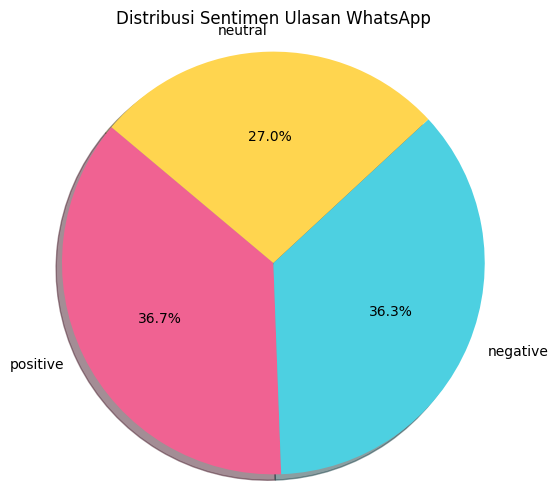


--- Visualisasi Word Cloud per Sentimen ---


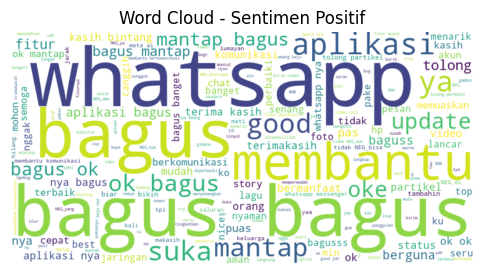

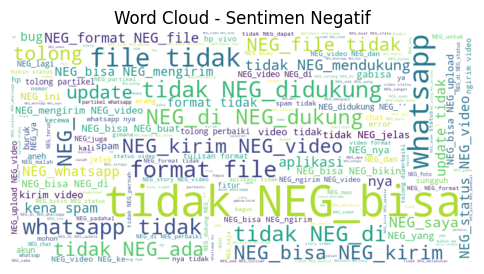

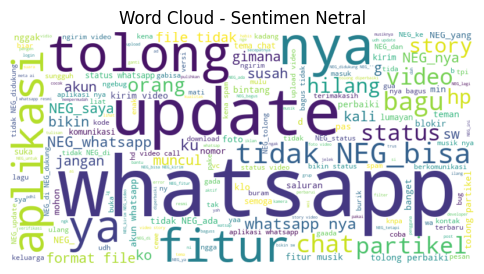

In [32]:
# Visualisasi Hasil Sentimen

sentiment_counts = cleaned_reviews_df['sentiment_lexicon_updated'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#F06292', '#4DD0E1', '#FFD54F']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribusi Sentimen Ulasan WhatsApp')
plt.axis('equal') 
plt.show()

print("\n--- Visualisasi Word Cloud per Sentimen ---")

# 1. Word Cloud untuk Sentimen Positif
df_positive = cleaned_reviews_df[cleaned_reviews_df['sentiment_lexicon_updated'] == 'positive']
text_positive = ' '.join(df_positive['content_processed'].astype(str))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(text_positive)

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Positif')
plt.show()

# 2. Word Cloud untuk Sentimen Negatif
df_negative = cleaned_reviews_df[cleaned_reviews_df['sentiment_lexicon_updated'] == 'negative']
text_negative = ' '.join(df_negative['content_processed'].astype(str))

wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(text_negative)

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Negatif')
plt.show()

# 3. Word Cloud untuk Sentimen Netral
df_neutral = cleaned_reviews_df[cleaned_reviews_df['sentiment_lexicon_updated'] == 'neutral']
text_neutral = ' '.join(df_neutral['content_processed'].astype(str))

wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(text_neutral)

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Netral')
plt.show()

In [33]:
# Menyimpan Hasil Akhir dalam file CSV
nama_file_hasil = 'ulasan_aplikasi.csv'
cleaned_reviews_df.to_csv(nama_file_hasil, index=False, encoding='utf-8')
print(f"\n\nHasil analisis sentimen seluruh ulasan Whatsapp disimpan ke file: {nama_file_hasil}")

print("\nSelesai melakukan scraping, EDA, preprocessing, dan analisis sentimen pada seluruh ulasan WhatsApp!")



Hasil analisis sentimen seluruh ulasan Whatsapp disimpan ke file: ulasan_aplikasi.csv

Selesai melakukan scraping, EDA, preprocessing, dan analisis sentimen pada seluruh ulasan WhatsApp!
